<a href="https://colab.research.google.com/github/kridtapon/Momentum-Drift-Strategy/blob/main/Momentum_Drift_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.3 MB/s eta 0:00:00


In [1]:
pip install --upgrade yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate Detrended Price Oscillator (DPO)
def calculate_dpo(df, period=20):
    """
    Calculate Detrended Price Oscillator (DPO).
    """
    shifted_sma = df['Close'].rolling(window=period).mean().shift(int(period / 2) + 1)
    dpo = df['Close'] - shifted_sma
    return dpo

# Function to calculate Smoothed Rate of Change (S-ROC)
def calculate_sroc(df, period=14, smoothing=3):
    """
    Calculate Smoothed Rate of Change (S-ROC).
    """
    roc = (df['Close'] - df['Close'].shift(period)) / df['Close'].shift(period) * 100
    sroc = roc.rolling(window=smoothing).mean()  # Apply smoothing
    return sroc

# Define the stock symbol and time period
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate DPO and S-ROC
df['DPO'] = calculate_dpo(df, period=20)
df['SROC'] = calculate_sroc(df, period=14, smoothing=3)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Define Entry and Exit signals based on DPO & S-ROC
df['Entry'] = (df['DPO'] > 0) & (df['SROC'] > df['SROC'].shift(1))  # DPO > 0 and S-ROC increasing
df['Exit'] = (df['DPO'] < 0) & (df['SROC'] < df['SROC'].shift(1))  # DPO < 0 and S-ROC decreasing

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sharpe_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'calmar_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'omega_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sortino_ratio' requires frequency to be set
  warnings.warn(warning_message)


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                            262209.12526
Total Return [%]                       162.209125
Benchmark Return [%]                   180.172876
Max Gross Exposure [%]                      100.0
Total Fees Paid                        9224.61879
Max Drawdown [%]                         48.42739
Max Drawdown Duration                       670.0
Total Trades                                   34
Total Closed Trades                            34
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            32.352941
Best Trade [%]                         160.165794
Worst Trade [%]                         -9.845989
Avg Winning Trade [%]                   25.166994
Avg Losing Trade [%]                    -4.331706


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools

# Function to calculate Detrended Price Oscillator (DPO)
def calculate_dpo(df, period=20):
    """
    Calculate Detrended Price Oscillator (DPO).
    """
    shifted_sma = df['Close'].rolling(window=period).mean().shift(int(period / 2) + 1)
    dpo = df['Close'] - shifted_sma
    return dpo

# Function to calculate Smoothed Rate of Change (S-ROC)
def calculate_sroc(df, period=14, smoothing=3):
    """
    Calculate Smoothed Rate of Change (S-ROC).
    """
    roc = (df['Close'] - df['Close'].shift(period)) / df['Close'].shift(period) * 100
    sroc = roc.rolling(window=smoothing).mean()  # Apply smoothing
    return sroc

# Define the stock symbol and time period
symbol = 'EBAY'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Optimization function to run the backtest with different parameter sets using itertools
def optimize_strategy(df, dpo_periods, sroc_periods, sroc_smoothings):
    best_total_return = -np.inf  # Track best total_return ratio
    best_params = None
    best_portfolio = None

    # Loop through parameter grid using itertools.product for all combinations
    for dpo_period, sroc_period, sroc_smoothing in itertools.product(dpo_periods, sroc_periods, sroc_smoothings):
        # Calculate DPO and S-ROC with current parameters
        df['DPO'] = calculate_dpo(df, period=dpo_period)
        df['SROC'] = calculate_sroc(df, period=sroc_period, smoothing=sroc_smoothing)

        # Filter data for the test period (2020-2025)
        df_filter = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

        # Define Entry and Exit signals based on DPO & S-ROC
        df_filter['Entry'] = (df_filter['DPO'] > 0) & (df_filter['SROC'] > df_filter['SROC'].shift(5))
        df_filter['Exit'] = (df_filter['DPO'] < 0) & (df_filter['SROC'] < df_filter['SROC'].shift(5))

        # Backtest using vectorbt
        portfolio = vbt.Portfolio.from_signals(
            close=df_filter['Close'],
            entries=df_filter['Entry'],
            exits=df_filter['Exit'],
            init_cash=100_000,
            fees=0.001
        )

        # Calculate total_return for current portfolio
        total_return = portfolio.stats()['Total Return [%]']

        # If the total_return is the best, store the result
        if total_return > best_total_return:
            best_total_return = total_return
            best_params = (dpo_period, sroc_period, sroc_smoothing)
            best_portfolio = portfolio

    return best_params, best_portfolio

# Define the range of parameters for optimization
dpo_periods = range(10, 31)  # Try DPO periods from 10 to 30
sroc_periods = range(10, 31)  # Try S-ROC periods from 10 to 30
sroc_smoothings = range(1, 6)  # Try smoothing values from 1 to 5

# Run optimization
best_params, best_portfolio = optimize_strategy(df, dpo_periods, sroc_periods, sroc_smoothings)

# Output the best parameters
print(f"Best Parameters: DPO Period: {best_params[0]}, S-ROC Period: {best_params[1]}, S-ROC Smoothing: {best_params[2]}")

# Display performance metrics for the best portfolio
print(best_portfolio.stats())

# Plot the equity curve of the best portfolio
best_portfolio.plot().show()


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set

<ipython-input-4-57371b386a53>:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-57371b386a53>:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/loca

Best Parameters: DPO Period: 12, S-ROC Period: 19, S-ROC Smoothing: 5
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           225763.569243
Total Return [%]                       125.763569
Benchmark Return [%]                    86.064711
Max Gross Exposure [%]                      100.0
Total Fees Paid                      11419.425342
Max Drawdown [%]                        32.551061
Max Drawdown Duration                       405.0
Total Trades                                   32
Total Closed Trades                            32
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                43.75
Best Trade [%]                          74.773115
Worst Trade [%]                         -10.66278
Avg Winning Trade [%]         

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set

<ipython-input-7-dfd1c94700fc>:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-7-dfd1c94700fc>:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/loca

Best Parameters: DPO Period: 12, S-ROC Period: 19, S-ROC Smoothing: 5
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           225763.569243
Total Return [%]                       125.763569
Benchmark Return [%]                    86.064711
Max Gross Exposure [%]                      100.0
Total Fees Paid                      11419.425342
Max Drawdown [%]                        32.551061
Max Drawdown Duration                       405.0
Total Trades                                   32
Total Closed Trades                            32
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                43.75
Best Trade [%]                          74.773115
Worst Trade [%]                         -10.66278
Avg Winning Trade [%]         

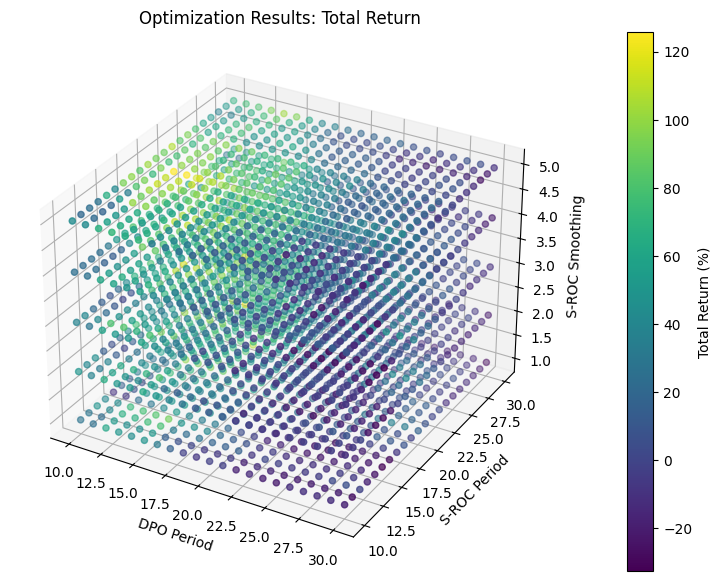

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to calculate Detrended Price Oscillator (DPO)
def calculate_dpo(df, period=20):
    """
    Calculate Detrended Price Oscillator (DPO).
    """
    shifted_sma = df['Close'].rolling(window=period).mean().shift(int(period / 2) + 1)
    dpo = df['Close'] - shifted_sma
    return dpo

# Function to calculate Smoothed Rate of Change (S-ROC)
def calculate_sroc(df, period=14, smoothing=3):
    """
    Calculate Smoothed Rate of Change (S-ROC).
    """
    roc = (df['Close'] - df['Close'].shift(period)) / df['Close'].shift(period) * 100
    sroc = roc.rolling(window=smoothing).mean()  # Apply smoothing
    return sroc

# Define the stock symbol and time period
symbol = 'EBAY'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Optimization function to run the backtest with different parameter sets using itertools
def optimize_strategy(df, dpo_periods, sroc_periods, sroc_smoothings):
    best_total_return = -np.inf  # Track best total_return ratio
    best_params = None
    best_portfolio = None
    results = []  # To store results for plotting

    # Loop through parameter grid using itertools.product for all combinations
    for dpo_period, sroc_period, sroc_smoothing in itertools.product(dpo_periods, sroc_periods, sroc_smoothings):
        # Calculate DPO and S-ROC with current parameters
        df['DPO'] = calculate_dpo(df, period=dpo_period)
        df['SROC'] = calculate_sroc(df, period=sroc_period, smoothing=sroc_smoothing)

        # Filter data for the test period (2020-2025)
        df_filter = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

        # Define Entry and Exit signals based on DPO & S-ROC
        df_filter['Entry'] = (df_filter['DPO'] > 0) & (df_filter['SROC'] > df_filter['SROC'].shift(5))
        df_filter['Exit'] = (df_filter['DPO'] < 0) & (df_filter['SROC'] < df_filter['SROC'].shift(5))

        # Backtest using vectorbt
        portfolio = vbt.Portfolio.from_signals(
            close=df_filter['Close'],
            entries=df_filter['Entry'],
            exits=df_filter['Exit'],
            init_cash=100_000,
            fees=0.001
        )

        # Calculate total_return for current portfolio
        total_return = portfolio.stats()['Total Return [%]']

        # Store the result (for 3D plot)
        results.append((dpo_period, sroc_period, sroc_smoothing, total_return))

        # If the total_return is the best, store the result
        if total_return > best_total_return:
            best_total_return = total_return
            best_params = (dpo_period, sroc_period, sroc_smoothing)
            best_portfolio = portfolio

    return best_params, best_portfolio, results

# Define the range of parameters for optimization
dpo_periods = range(10, 31)  # Try DPO periods from 10 to 30
sroc_periods = range(10, 31)  # Try S-ROC periods from 10 to 30
sroc_smoothings = range(1, 6)  # Try smoothing values from 1 to 5

# Run optimization
best_params, best_portfolio, results = optimize_strategy(df, dpo_periods, sroc_periods, sroc_smoothings)

# Output the best parameters
print(f"Best Parameters: DPO Period: {best_params[0]}, S-ROC Period: {best_params[1]}, S-ROC Smoothing: {best_params[2]}")

# Display performance metrics for the best portfolio
print(best_portfolio.stats())

# Plot the equity curve of the best portfolio
best_portfolio.plot().show()

# Extract the results for plotting
dpo_periods_all, sroc_periods_all, sroc_smoothings_all, total_returns_all = zip(*results)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color mapping
sc = ax.scatter(dpo_periods_all, sroc_periods_all, sroc_smoothings_all, c=total_returns_all, cmap='viridis', marker='o')

# Labels and title
ax.set_xlabel('DPO Period')
ax.set_ylabel('S-ROC Period')
ax.set_zlabel('S-ROC Smoothing')
ax.set_title('Optimization Results: Total Return')

# Add colorbar (color panel) to show the color scale
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Total Return (%)')

# Show plot
plt.show()
